<a href="https://colab.research.google.com/github/Dimonfordont/DS_course/blob/main/LLM/multimidal/Llava_NeXT_inference_4bit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Inferencing Llava: a large multi-modal

Following is architecture of llava
![image/png](https://cdn-uploads.huggingface.co/production/uploads/62441d1d9fdefb55a0b7d12c/FPshq08TKYD0e-qwPLDVO.png)

The architecutre is a pure decoder-based text model that takes concatenated vision hidden states with text hidden states.


In [1]:
!pip install -q -U bitsandbytes accelerate transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.4/122.4 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 36.8 MB/s eta 0:00:00


## Load an image

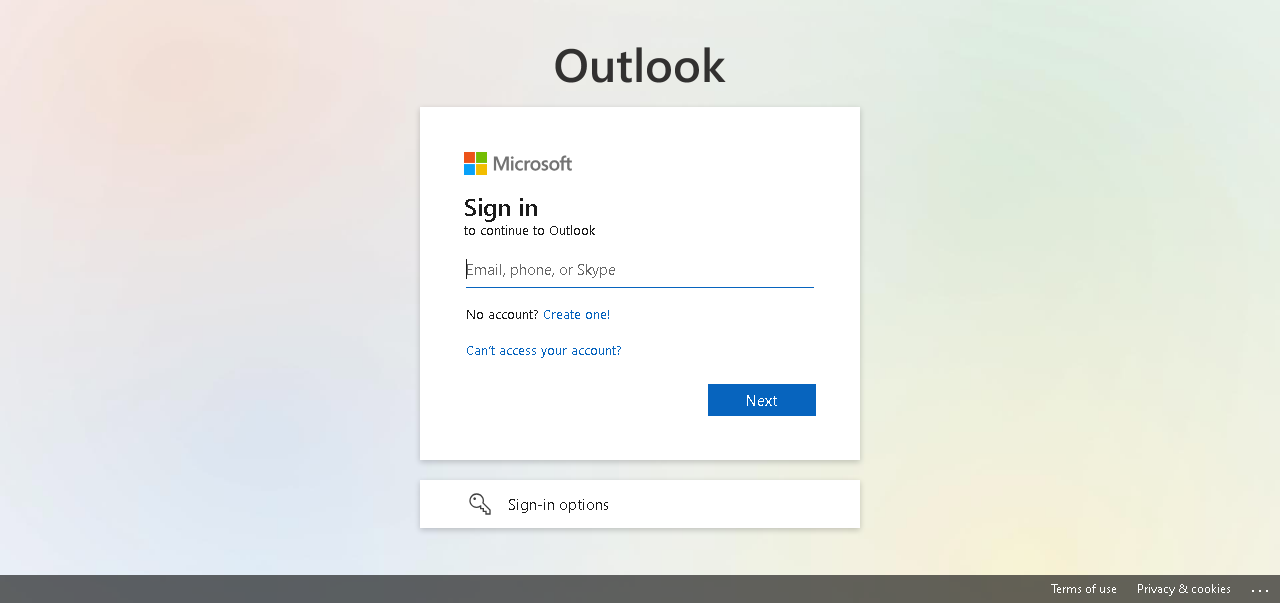

In [2]:
from PIL import Image

image_png = "logo11.png"
image = Image.open(image_png)
image

## Preparing the quantization config to load the model in 4bit precision

In [3]:
import torch
from transformers import BitsAndBytesConfig

quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16)

In [4]:
from transformers import LlavaNextProcessor, LlavaNextForConditionalGeneration

## Load the model

In [5]:

import torch
from PIL import Image
import requests


model_id = "llava-hf/llava-v1.6-mistral-7b-hf"
processor = LlavaNextProcessor.from_pretrained(model_id)
model = LlavaNextForConditionalGeneration.from_pretrained(model_id,
                                                          low_cpu_mem_usage=True,
                                                          quantization_config= quantization_config)

preprocessor_config.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.07k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/41.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/552 [00:00<?, ?B/s]

processor_config.json:   0%|          | 0.00/176 [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

Some kwargs in processor config are unused and will not have any effect: num_additional_image_tokens. 


config.json:   0%|          | 0.00/1.28k [00:00<?, ?B/s]

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


model.safetensors.index.json:   0%|          | 0.00/70.2k [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/380M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

It is important to prompt the model wth a specific format

In [21]:
conversation = [
    {

      "role": "user",
      "content": [
          {"type": "text", "text":
           "You are an S&P specialist tasked with evaluating company websties. Your task is to define the sector if industry the company belongs to based on the login page. What is the company and industry sector on the image. Your reply should only be in JSON output for example\n {'company': 'dhl', 'industry': 'transportation'}"},
          {"type": "image"},
        ],
    },
]

## Inference

In [22]:
max_new_tokens=100
output = model.generate(**inputs, max_new_tokens=max_new_tokens)
print(processor.decode(output[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


[INST]  
You are an S&P specialist tasked with evaluating company websties. Your task is to define the sector if industry the company belongs to based on the login page. What is the company and industry sector on the image. Your reply should only be in JSON output for example
 ```json {'company': 'dhl', 'industry': 'transportation'}.``` [/INST] ```json {
  "company": "Microsoft",
  "industry": "Technology"
}
``` 


In [23]:
toparse = processor.decode(output[0], skip_special_tokens=True).split('/INST]')[1]
print(toparse)

 ```json {
  "company": "Microsoft",
  "industry": "Technology"
}
``` 


In [30]:
result = json.loads(toparse.replace("```json", "").replace("```", "").strip())
result

{'company': 'Microsoft', 'industry': 'Technology'}